In [1]:
import importlib
import micasense.imageset
import micasense.capture
import micasense.imageset as imageset
import micasense.capture as capture
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import exiftool
import datetime
from math import ceil
from tqdm import tqdm
import re
import glob
import contextlib
from PIL import Image

import algorithms.mutils as mutils
import algorithms.radiometric_calib_utils as rcu
import algorithms.extract_spectral as espect
import algorithms.flight_attributes
import algorithms.validate_algorithm

importlib.reload(algorithms.validate_algorithm)
importlib.reload(algorithms.flight_attributes)

import algorithms.flight_attributes as FlightAttributes
import algorithms.validate_algorithm as ValidateAlgo

# Import all folder

In [2]:
rootDir = r"D:\EPMC_flight\pandanRes"
dirsList = [os.path.join(rootDir,f) for f in sorted(os.listdir(rootDir)) if f.endswith("overlap")]
rawImgDirs = [os.path.join(dirs,f) for dirs in dirsList for f in os.listdir(dirs) if f == "RawImg"]

# list all panel imges corresponding to the folder
panelImges = [0,0,0,0,0,55,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0]

assert len(panelImges) == len(rawImgDirs), "every directory must have one QR image"
folderPanelDir = []
for folderName, imgIdx in zip(rawImgDirs,panelImges):
    # folderPanelDir[folderName] = imgIdx
    folderPanelDir.append({'folderName': folderName, 'panelIndex': imgIdx})

folderPanelDir[0]

{'folderName': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\RawImg',
 'panelIndex': 0}

In [3]:
selectedIdx = 0

## Import saved band_aligned images

In [4]:
imagePath =  folderPanelDir[selectedIdx]['folderName'] #r"D:\EPMC_flight\pandanResTest\F1\RawImg"
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_fligh

## Import flight attributes data

In [5]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
0,2023-09-20 02:37:46.734108+00:00,1.318984,103.736576,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280
1,2023-09-20 02:38:25.652070+00:00,1.318969,103.736552,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994
2,2023-09-20 02:40:02.646889+00:00,1.318935,103.736667,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003
3,2023-09-20 02:40:27.129650+00:00,1.318957,103.736711,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652
4,2023-09-20 02:40:28.687747+00:00,1.318989,103.736740,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2023-09-20 02:42:37.754046+00:00,1.318995,103.736652,52.113,IMG_0077_1.tif,LxWxxE0dKGSKCJPD9emk,-1.710094,-0.109079,-0.110542,0.324510,0.278215,0.215442,0.135719,0.169883,0.300243,0.292801,0.216655,0.190829,0.175554
78,2023-09-20 02:42:40.221641+00:00,1.318985,103.736609,52.254,IMG_0078_1.tif,vOZMfLXGQb0fb52EGfk8,-1.701558,-0.107945,-0.112222,0.322847,0.276751,0.214274,0.134965,0.168932,0.298718,0.291270,0.215472,0.189780,0.174602
79,2023-09-20 02:42:42.735583+00:00,1.318975,103.736563,52.359,IMG_0079_1.tif,o4SQ3aYYcZEyDzjKdJhi,-1.701601,0.009124,-0.105172,0.321727,0.275801,0.213584,0.134510,0.168352,0.297657,0.290258,0.214756,0.189152,0.174039
80,2023-09-20 02:44:00.101050+00:00,1.318983,103.736560,24.732,IMG_0080_1.tif,cbN2MVydgBF9ySm3oP9I,0.578686,-0.115606,-0.048260,0.322058,0.274594,0.213920,0.134003,0.168978,0.296372,0.289454,0.214553,0.190291,0.175322


## View flight altitude

In [6]:
# helper function that is only relevant to my file naming
def get_heights():
    measuredHeight = np.median(flight_attributes_df['altitude'])
    # where the folder name contains the flight height information e.g. ...15H...25H...
    actualHeight = int(re.search('[0-9][0-9]H',os.path.dirname(imagePath)).group(0).replace('H',''))
    DEM_offset_height = int(measuredHeight - actualHeight)
    print(f'offset height: {DEM_offset_height}m')
    return {'measuredHeight':measuredHeight, 
    'actualHeight':actualHeight, 
    'height_max':np.max(flight_attributes_df['altitude'].values),
    'height_min':np.min(flight_attributes_df['altitude'].values),
    'DEM_offset_height':DEM_offset_height}

height_dict = get_heights()

offset height: 26m


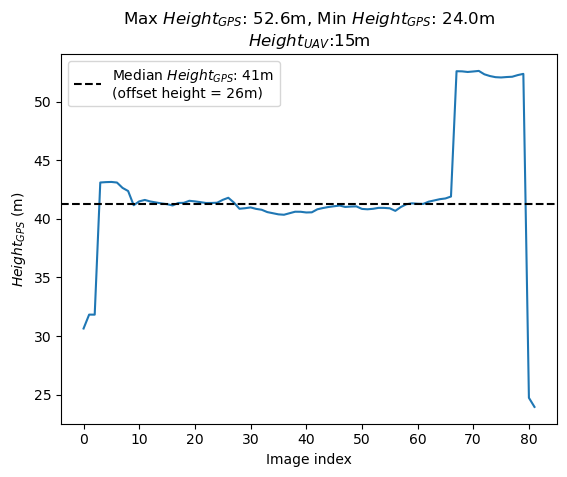

In [7]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
height_max = height_dict['height_max']
height_min = height_dict['height_min']
measuredHeight = height_dict['measuredHeight']
actualHeight = height_dict['actualHeight']
DEM_offset_height = height_dict['DEM_offset_height']
plt.axhline(y=measuredHeight, ls='--',c='k',label=r'Median $Height_{GPS}$:' f" {int(measuredHeight)}m\n(offset height = {DEM_offset_height}m)")
plt.title(r'Max $Height_{GPS}$:' + f' {height_max:.1f}m, ' + r'Min $Height_{GPS}$: ' + f'{height_min:.1f}m\n' + r'$Height_{UAV}$:' +f'{actualHeight}m')
plt.ylabel(r'$Height_{GPS}$ (m)')
plt.xlabel('Image index')
plt.legend()
# save fig
parentDir = os.path.join(os.path.dirname(imagePath),"images")
os.mkdir(parentDir) if not os.path.exists(parentDir) else None
fname = os.path.join(parentDir,f'height_timeseries.png')
plt.savefig(fname)

plt.show()

## Detect points

In [8]:
def readSelectedGPS(imagePath):
    fp = os.path.join(os.path.dirname(imagePath),'flight_attributes','gps_index.txt')
    with open(fp, "r") as output:
        idx_list = output.readlines()
    intList = sorted([int(i.replace('\n','')) for i in idx_list])
    print(intList)
    assert len(intList)%2 == 0
    n = len(intList)//2
    listIndex = [np.arange(intList[i*2],intList[i*2+1]+1).tolist() for i in range(n)]
    return [i for l in listIndex for i in l]
ls_idx = readSelectedGPS(imagePath)

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


In [9]:
flight_attributes_df.iloc[ls_idx,:]

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
10,2023-09-20 02:40:46.867245+00:00,1.319223,103.736855,41.484,IMG_0010_1.tif,TGMjtoMK4lZZHwz0gWE2,0.098322,-0.067554,-0.011150,0.389261,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836
11,2023-09-20 02:40:48.333197+00:00,1.319285,103.736855,41.606,IMG_0011_1.tif,Vbmk53xTHky4YeQ3tY5q,0.105641,-0.061187,-0.012180,0.388711,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483
12,2023-09-20 02:40:49.529728+00:00,1.319329,103.736855,41.475,IMG_0012_1.tif,sHfimxse9xw3yckAG5jT,0.108555,-0.092849,-0.016617,0.388261,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233
13,2023-09-20 02:40:50.856883+00:00,1.319371,103.736854,41.391,IMG_0013_1.tif,JTvwKvY3Wp1QRFABs177,0.120106,-0.088623,-0.023227,0.387690,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892
14,2023-09-20 02:40:52.169954+00:00,1.319422,103.736854,41.308,IMG_0014_1.tif,GSCS3gkaTUELPKSWJdea,0.124905,-0.094922,-0.029860,0.387213,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612
15,2023-09-20 02:40:53.589501+00:00,1.319472,103.736854,41.245,IMG_0015_1.tif,a9W6IeTeApFvdy6YZmoD,0.129650,-0.112619,-0.032220,0.386693,0.333877,0.262015,0.164282,0.205592,0.355474,0.350284,0.262523,0.231655,0.213320
19,2023-09-20 02:41:02.187689+00:00,1.319453,103.736917,41.534,IMG_0019_1.tif,JMwCyxZYTwIaNl8s1JqS,3.134863,-0.181926,-0.043723,0.383928,0.332671,0.260078,0.163659,0.204055,0.353862,0.348756,0.261007,0.229503,0.210897
20,2023-09-20 02:41:03.520863+00:00,1.319400,103.736917,41.484,IMG_0020_1.tif,rvW1ZR6L15nzlWYzQv47,3.107451,-0.123240,-0.022599,0.382603,0.331665,0.259325,0.163180,0.203390,0.352640,0.347652,0.260238,0.228773,0.210203
21,2023-09-20 02:41:04.723871+00:00,1.319355,103.736917,41.416,IMG_0021_1.tif,9QsYgvMByLtvzwrE8a76,3.078801,-0.140075,-0.019666,0.381419,0.330739,0.258621,0.162748,0.202787,0.351560,0.346650,0.259524,0.228103,0.209575
22,2023-09-20 02:41:05.909510+00:00,1.319319,103.736917,41.346,IMG_0022_1.tif,k69jmBnbJCmeLakHMOcd,3.057578,-0.132865,-0.017881,0.380082,0.329648,0.257777,0.162212,0.202077,0.350332,0.345482,0.258667,0.227319,0.208846


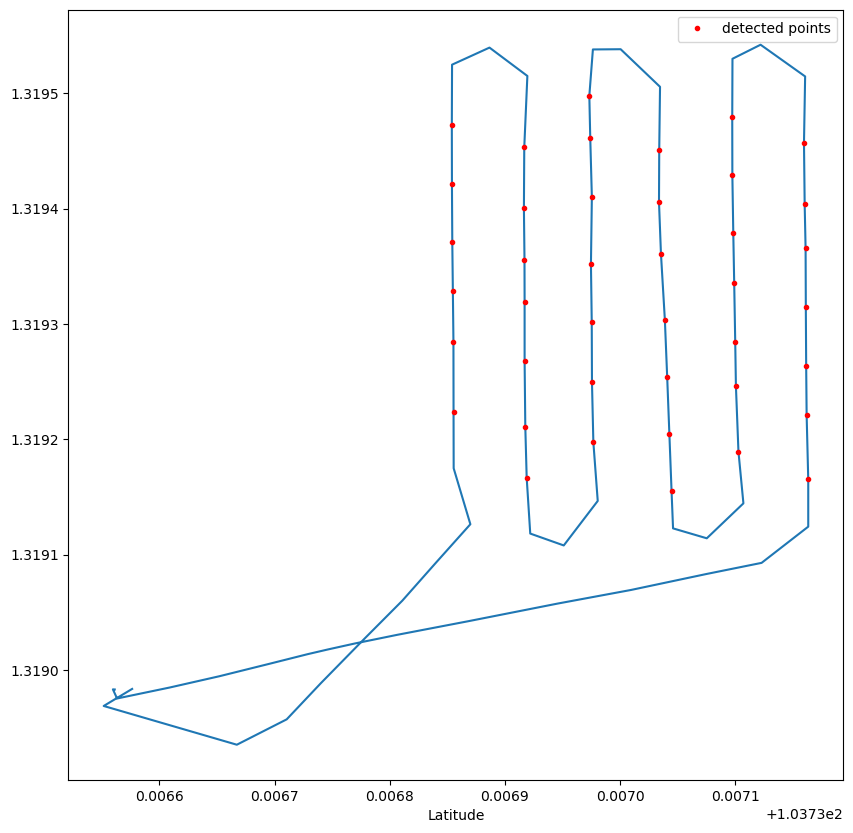

[10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65]


In [10]:
DL = FlightAttributes.DetectLines(flight_attributes_df, n = 3, thresh=0.99, plot=True)
# ls_idx = list(range(8,13)) + list(range(16,20)) + list(range(23,28)) + list(range(31, 36))
# ls_idx = [int(os.path.splitext(i)[0].split('_')[1]) for i in flight_attributes_df.image_name.to_list()]
flight_points=flight_attributes_df.iloc[ls_idx,1:3].reset_index().rename(columns={"latitude":'lat','longitude':'lon'}).to_dict('records')

# flight_att_dict = flight_attributes_df.iloc[:,1:4].reset_index().rename(columns={"latitude":'lat','longitude':'lon'}).to_dict('records')
# flight_points = [d for d in flight_att_dict if (d['altitude'] < measuredHeight+1 and d['altitude'] > measuredHeight-1)]
flight_points = DL.get_points(flight_points = ls_idx)

# flight_points = DL.get_points()
print(flight_points)

## Interpolate Flight
- estimate flight angle using coordinates (`estimate_angle = "coord"`)
- estimate flight angle using yaw (`estimate_angle = "yaw"`)

82it [00:00, 1712.90it/s]

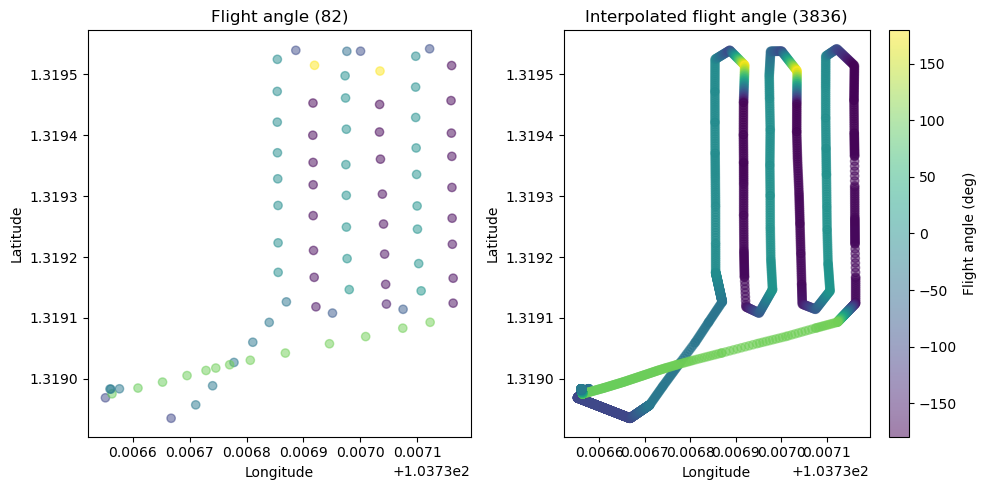

,timestamp,timedelta,latitude,longitude,altitude,flight_angle,north_vec,east_vec,image_name,capture_id,...,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,index
0,2023-09-20 02:37:46.734108+00:00,0.0,1.318984,103.736576,30.643000,-36.420749,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
1,2023-09-20 02:37:46.834108+00:00,0.1,1.318984,103.736576,30.646045,-36.587568,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
2,2023-09-20 02:37:46.934108+00:00,0.2,1.318984,103.736576,30.649090,-36.754387,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
3,2023-09-20 02:37:47.034108+00:00,0.3,1.318983,103.736576,30.652135,-36.921207,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
4,2023-09-20 02:37:47.134108+00:00,0.4,1.318983,103.736576,30.655179,-37.088026,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0


In [11]:
imagePath = folderPanelDir[selectedIdx]['folderName']#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = "yaw")
df_interpolated = IF.interpolate_flight()
df_interpolated.head()

# Time delay correction

82it [00:00, 1712.86it/s]


rows shifted: -20
shape of canvas(4891, 4179, 3)
rows shifted: -17
shape of canvas(4878, 4181, 3)
rows shifted: -14
shape of canvas(4810, 4182, 3)
rows shifted: -11
shape of canvas(4732, 4181, 3)
rows shifted: -8
shape of canvas(4654, 4181, 3)
rows shifted: -5
shape of canvas(4444, 4188, 3)
rows shifted: -2
shape of canvas(4241, 4189, 3)
rows shifted: 0
shape of canvas(4156, 4189, 3)


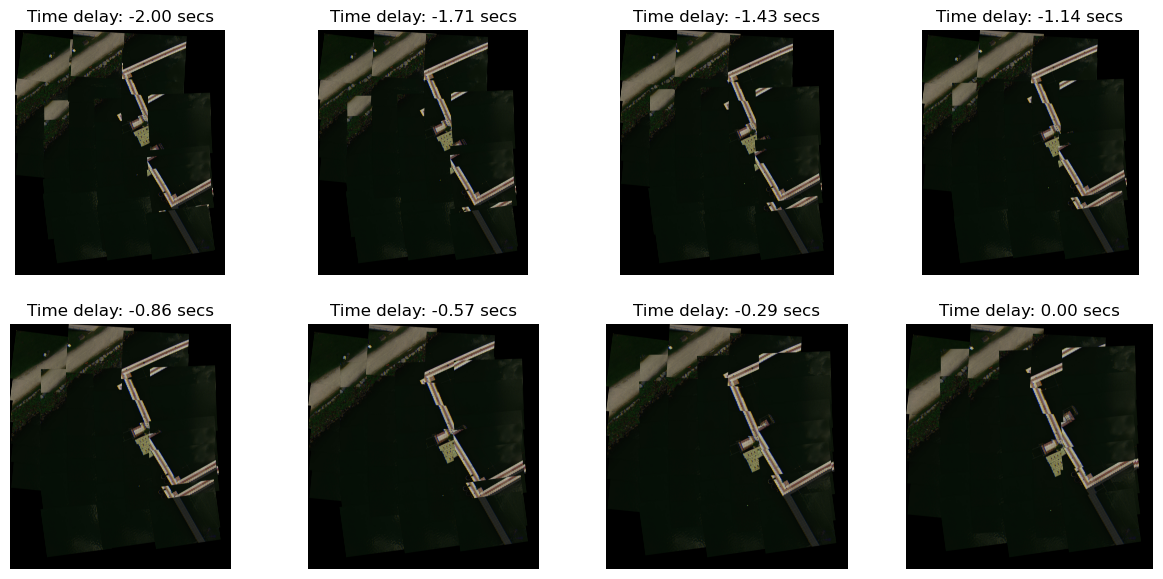

In [12]:
# estimate the bounds of time delay correction
est_time_delay1 = 0
est_time_delay2 = -2

# indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
estimate_angle = "yaw"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = 21
IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight(plot=False)

n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,7))

for i, (td,ax) in enumerate(zip(np.linspace(est_time_delay2,est_time_delay1, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td, 
                                                 columns_to_shift = ['timestamp', 'timedelta', 'latitude', 'longitude'])
    df_cropped = df1.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.axis('off')
    ax.set_title(f'Time delay: {td:.2f} secs')
plt.show()

82it [00:00, 1612.14it/s]


rows shifted: 0
shape of canvas(4156, 4189, 3)


82it [00:00, 1868.68it/s]


rows shifted: -5
shape of canvas(4444, 4188, 3)


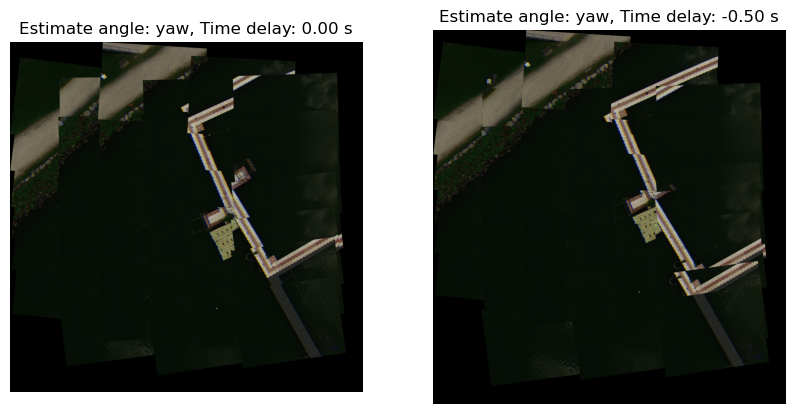

In [13]:
# indicate optimal time delay correction, change `td` to whatever
td = -0.5
# indicate what method to estimate flight_angle in `estimate_angle` - "coord" or "yaw"
estimate_angle = "yaw"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = 21
# interpolate df
fig, axes = plt.subplots(1,2,figsize=(10,5))
for i,timedelta in enumerate([0,td]):
    IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                            interpolate_milliseconds=100, 
                                            estimate_angle = estimate_angle)
    df_interpolated = IF.interpolate_flight(plot=False)
    df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=timedelta, 
                                                 columns_to_shift = ['timestamp', 'timedelta', 'latitude', 'longitude'])
    # df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=timedelta)
    df_cropped = df_corrected.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)

    axes[i].imshow(im_display)
    axes[i].axis('off')
    axes[i].set_title(f'Estimate angle: {estimate_angle}, Time delay: {timedelta:.2f} s')

# # save fig
# parentDir = os.path.join(os.path.dirname(imagePath),"images")
# os.mkdir(parentDir) if not os.path.exists(parentDir) else None
# td_str = str(np.abs(td)).replace('.','')
# td_str = f'n{td_str}' if np.sign(td) < 0 else f'p{td_str}'
# fname = os.path.join(parentDir,f'timedelay_{td_str}_{estimate_angle}_height{int(DEM_offset_height)}.png')
# plt.savefig(fname)

plt.show()

In [204]:
from scipy.interpolate import griddata
def interpolate_timestamp(df,column_names = ['latitude','longitude'], milliseconds=100):
    """
    :param df (pd.DataFrame): column names must include timestamp, latitude, longitude, altitude, flight_angle
    :param column_names (list of str): list of columns to interpolate
    :param milliseconds (float): timedelta in milliseconds, interpolate between two timestamps at 100ms frequency
    linear interpolation using timedelta
    returns a tuple of (original dataframe, interpolated dataframe)
    """
    if not all([i in df.columns for i in column_names]):
        raise NameError(f'at least one name does not exist: {column_names}')
    
    freq = datetime.timedelta(milliseconds=milliseconds)
    # another check to ensure that datetime is correct and makes sense, 
    # sometimes the first row's date will start at year 1970 which will increase interpolate time and memory overflow
    median_dt = df.timestamp.dt.year[len(df.index)//2]
    idxAbnormalDates = df.index[df.timestamp.dt.year < median_dt].tolist() #to filter out dates where the year differed significantly
    if len(idxAbnormalDates) > 0:
        datesToFill = df['timestamp'].iloc[[idx+1 for idx in idxAbnormalDates]] - freq
        df.timestamp = np.where(df.timestamp.dt.year < median_dt, datesToFill, df.timestamp)

    date_range_list = []
    for i, rows in df.iterrows():
        if i == len(df.index) -1:
            pass
        else:
            daterange = pd.date_range(start=rows['timestamp'], end=df['timestamp'][i+1], freq=freq,closed='left').to_series() # date arange
            daterange = daterange.reset_index()
            date_range_list.append(daterange.iloc[:,0])
    
    interpolated_timestamp = pd.concat(date_range_list)
    # print(interpolated_timestamp)
    timedelta_series = interpolated_timestamp - df['timestamp'][df.index[0]]
    timedelta_series = timedelta_series.dt.total_seconds() #returns time delta in total_seconds

    og_timestamp = df['timestamp']
    og_timedelta_series = og_timestamp - df['timestamp'][df.index[0]]
    og_timedelta_series = og_timedelta_series.dt.total_seconds()
    og_dict = {'timestamp': og_timestamp, 'timedelta': og_timedelta_series}
    for names in column_names:
        og_dict[names] = df[names]
    og_df = pd.DataFrame(og_dict)
    
    interpolated_dict = {'timestamp': interpolated_timestamp,'timedelta':timedelta_series}
    for names in column_names:
        interpolated_dict[names] = griddata(og_timedelta_series, df[names], timedelta_series, method='linear')
    interpolated_df = pd.DataFrame(interpolated_dict)
    
    return og_df, interpolated_df

class InterpolateFlight:
    def __init__(self, df, interpolate_milliseconds=100, estimate_angle = "yaw",column_names = ['latitude','longitude']):
        """ 
        :param df (pd.DataFrame): imported from the folder 'flight_attributes'
        :param interpolate_milliseconds (int): interpolate timeseries every [x] milliseconds
        :param estimate_angle (str): "yaw" or "coord". either use yaw directly or calculate flight angle from coords
        :param column_names (list of str): column names in df
        """
        self.df = df
        self.interpolate_milliseconds = interpolate_milliseconds
        self.estimate_angle = estimate_angle
        self.column_names = column_names
    
    def append_flight_angle(self,df):
        """calculate flight angle (in degrees) and append to the df"""
        if self.estimate_angle == "yaw":
            df['flight_angle'] = -df['dls-yaw']/np.pi*180
        else:
            column_idx = [i for i,c in enumerate(df.columns.to_list()) if c in ['latitude','longitude']]
            angle_coord_list = []
            for i,rows in tqdm(df.iterrows()):
                if (i == 0) or (i == len(df.index)-1):
                    angle_coord_list.append(np.NaN)
                    pass
                else:
                    # estimate flight angle from 2 adjacent coordinates
                    flight_att_diff = df.iloc[[i-1,i+1],column_idx]
                    flight_att_diff = flight_att_diff.iloc[:,:2].values
                    flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
                    north_vec, east_vec = FlightAttributes.get_flight_direction(flight_att_diff)
                    if east_vec < 0:
                        flight_angle = flight_angle_coord # means rotation of image is positive (acw)
                    else:
                        flight_angle = -flight_angle_coord # means rotation of image is negative (cw)
                    angle_coord_list.append(flight_angle)
            # angle_coord_list.append(np.NaN)
            df['flight_angle'] = angle_coord_list
        
        df = df.ffill(axis=0).bfill(axis=0) #fill forward and fill backward
        return df
    
    def calculate_flight_direction(self, df):
        """ append north and east vec to df"""
        
        column_idx = [i for i,c in enumerate(df.columns.to_list()) if c in ['latitude','longitude']]
        north_vec_list = []
        east_vec_list = []
        for i,rows in tqdm(df.iterrows()):
            if (i == 0) or (i == len(df.index)-1):
                north_vec_list.append(np.NaN)
                east_vec_list.append(np.NaN)
                pass
            else:
                # estimate flight angle from 2 adjacent coordinates
                flight_att_diff = df.iloc[[i-1,i+1],column_idx]
                flight_att_diff = flight_att_diff.iloc[:,:2].values
                flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
                north_vec_list.append(flight_dir[0])
                east_vec_list.append(flight_dir[1])
        
        df['north_vec'] = north_vec_list
        df['east_vec'] = east_vec_list
        df = df.ffill(axis=0).bfill(axis=0) #fill forward and fill backward
        return df

    def interpolate_flight(self, plot=True):
        """returns an interpolated df"""
        flight_attributes_df = self.append_flight_angle(self.df)
        flight_attributes_df = self.calculate_flight_direction(flight_attributes_df)
        # convert to datetime format
        flight_attributes_df['timestamp'] = pd.to_datetime(flight_attributes_df['timestamp'])
        # interpolate df
        df, df_interpolated = interpolate_timestamp(flight_attributes_df,milliseconds=self.interpolate_milliseconds)
        # df_interpolated = self.append_flight_angle(df_interpolated)
        # common_columns = set(df_interpolated.columns.to_list()).intersection(set(flight_attributes_df.columns.to_list()))
        # common_columns = list(sorted(common_columns))
        df_interpolated = df_interpolated.merge(flight_attributes_df,how='outer',on=['timestamp']+self.column_names).ffill(axis=0)
        # df_interpolated = self.calculate_flight_direction(df_interpolated)
        # assign unique index for image name
        df_interpolated['index'] = df_interpolated['image_name'].str.split('_').str[1].astype(int)
        
        if plot is True:
            fig, axes = plt.subplots(1,2,figsize=(10,5))
            axes[0].scatter(df['longitude'],df['latitude'],c=df['flight_angle'],alpha=0.5)
            im = axes[1].scatter(df_interpolated['longitude'],df_interpolated['latitude'],c=df_interpolated['flight_angle'],alpha=0.5)
            cax = plt.colorbar(im,ax=axes[1])
            cax.set_label('Flight angle (deg)')
            axes[0].set_title(f'Flight angle ({len(df.index)})')
            axes[1].set_title(f'Interpolated flight angle ({len(df_interpolated.index)})')
            for ax in axes:
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
            plt.tight_layout()
            plt.show()
        
        return df_interpolated

82it [00:00, 1066.65it/s]
82it [00:00, 1156.79it/s]


rows shifted: 0
shape of canvas(4072, 4074, 3)


82it [00:00, 1225.85it/s]
82it [00:00, 902.55it/s]


rows shifted: -5
shape of canvas(4370, 4074, 3)


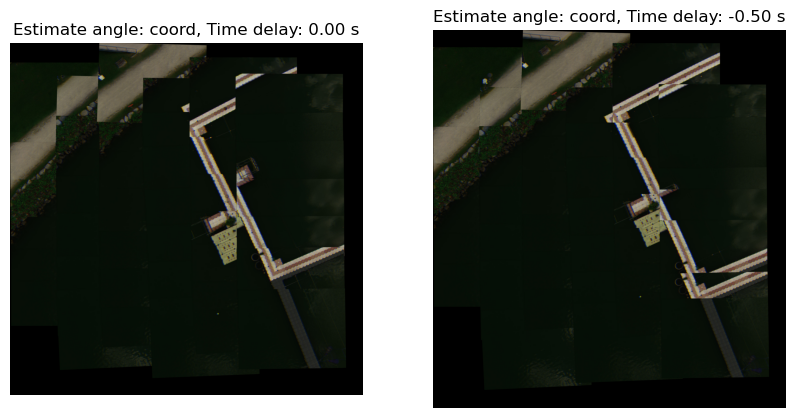

In [210]:
# indicate optimal time delay correction, change `td` to whatever
td = -0.5
# indicate what method to estimate flight_angle in `estimate_angle` - "coord" or "yaw"
estimate_angle = "coord"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = 21
# interpolate df
fig, axes = plt.subplots(1,2,figsize=(10,5))
for i,timedelta in enumerate([0,td]):
    IF = InterpolateFlight(flight_attributes_df, 
                                            interpolate_milliseconds=100, 
                                            estimate_angle = estimate_angle)
    df_interpolated = IF.interpolate_flight(plot=False)
    df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=timedelta)
    df_cropped = df_corrected.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)

    axes[i].imshow(im_display)
    axes[i].axis('off')
    axes[i].set_title(f'Estimate angle: {estimate_angle}, Time delay: {timedelta:.2f} s')

# # save fig
# parentDir = os.path.join(os.path.dirname(imagePath),"images")
# os.mkdir(parentDir) if not os.path.exists(parentDir) else None
# td_str = str(np.abs(td)).replace('.','')
# td_str = f'n{td_str}' if np.sign(td) < 0 else f'p{td_str}'
# fname = os.path.join(parentDir,f'timedelay_{td_str}_{estimate_angle}_height{int(DEM_offset_height)}.png')
# plt.savefig(fname)

plt.show()

In [212]:
df_cropped

,image_name,timestamp,timedelta,latitude,longitude,altitude,capture_id,dls-yaw,dls-pitch,dls-roll,...,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle,north_vec,east_vec,index
10,IMG_0010_1.tif,2023-09-20 02:40:47.367245+00:00,180.633137,1.319244,103.736855,41.484,TGMjtoMK4lZZHwz0gWE2,0.098322,-0.067554,-0.011150,...,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,0.104269,1.0,-1.0,10
11,IMG_0011_1.tif,2023-09-20 02:40:48.833197+00:00,182.099089,1.319303,103.736855,41.606,Vbmk53xTHky4YeQ3tY5q,0.105641,-0.061187,-0.012180,...,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,0.326778,1.0,-1.0,11
12,IMG_0012_1.tif,2023-09-20 02:40:50.029728+00:00,183.295620,1.319345,103.736855,41.475,sHfimxse9xw3yckAG5jT,0.108555,-0.092849,-0.016617,...,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,0.661585,1.0,-1.0,12
13,IMG_0013_1.tif,2023-09-20 02:40:51.356883+00:00,184.622775,1.319391,103.736854,41.391,JTvwKvY3Wp1QRFABs177,0.120106,-0.088623,-0.023227,...,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,0.492325,1.0,-1.0,13
14,IMG_0014_1.tif,2023-09-20 02:40:52.669954+00:00,185.935846,1.319439,103.736854,41.308,GSCS3gkaTUELPKSWJdea,0.124905,-0.094922,-0.029860,...,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,0.227363,1.0,-1.0,14
15,IMG_0015_1.tif,2023-09-20 02:40:54.089501+00:00,187.355393,1.319489,103.736854,41.245,a9W6IeTeApFvdy6YZmoD,0.129650,-0.112619,-0.032220,...,0.205592,0.355474,0.350284,0.262523,0.231655,0.213320,-0.055519,1.0,1.0,15
19,IMG_0019_1.tif,2023-09-20 02:41:02.687689+00:00,195.953581,1.319433,103.736917,41.534,JMwCyxZYTwIaNl8s1JqS,3.134863,-0.181926,-0.043723,...,0.204055,0.353862,0.348756,0.261007,0.229503,0.210897,178.504366,-1.0,-1.0,19
20,IMG_0020_1.tif,2023-09-20 02:41:04.020863+00:00,197.286755,1.319382,103.736917,41.484,rvW1ZR6L15nzlWYzQv47,3.107451,-0.123240,-0.022599,...,0.203390,0.352640,0.347652,0.260238,0.228773,0.210203,-179.882591,-1.0,1.0,20
21,IMG_0021_1.tif,2023-09-20 02:41:05.223871+00:00,198.489763,1.319340,103.736917,41.416,9QsYgvMByLtvzwrE8a76,3.078801,-0.140075,-0.019666,...,0.202787,0.351560,0.346650,0.259524,0.228103,0.209575,-179.577680,-1.0,1.0,21
22,IMG_0022_1.tif,2023-09-20 02:41:06.409510+00:00,199.675402,1.319300,103.736917,41.346,k69jmBnbJCmeLakHMOcd,3.057578,-0.132865,-0.017881,...,0.202077,0.350332,0.345482,0.258667,0.227319,0.208846,-179.934444,-1.0,1.0,22


# Time delay correction

- identify the optimal time delay for obtaining the optimal image alignment
- identify the optimal height for obtaining the accurate projection

82it [00:00, 1493.28it/s]


rows shifted: -20
shape of canvas(6740, 5161, 3)
rows shifted: -17
shape of canvas(6736, 5164, 3)


KeyboardInterrupt: 

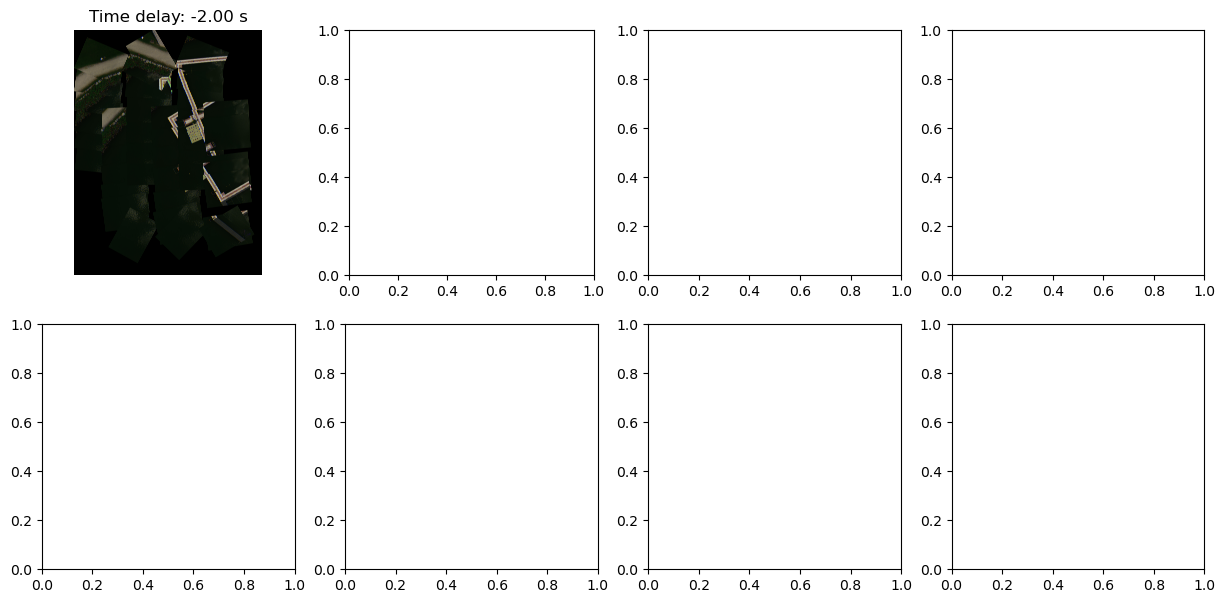

In [202]:
# estimate the bounds of time delay correction
# change the following bounds if needed to narrow the optimal time delay for finding the optimal image alignment
est_time_delay1 = 0
est_time_delay2 = -2
scale_factor = 1.05
height_steps = 6

for height in range(height_steps): # try offsets in height of up to 5m by 1meters
    DEM_offset_height = height_dict['DEM_offset_height'] - height
    # indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
    for estimate_angle in ["yaw","coord"]:

        IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                                interpolate_milliseconds=100, 
                                                estimate_angle = estimate_angle)
        df_interpolated = IF.interpolate_flight(plot=False)

        n_fig = 8
        fig, axes = plt.subplots(2,4, figsize=(15,7))

        for i, (td,ax) in enumerate(zip(np.linspace(est_time_delay2,est_time_delay1, n_fig),axes.flatten())):
            df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
            df_cropped = df1.iloc[flight_points,:]
            PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
            try:
                im_display = PG.plot_georeference(reduction_factor=5,plot=False, scale_factor=scale_factor)
            except:
                scale_factor *= 1.05
                im_display = PG.plot_georeference(reduction_factor=5,plot=False, scale_factor=scale_factor)
            ax.imshow(im_display)
            ax.set_title(f'Time delay: {td:.2f} s')
            ax.axis('off')

        correctedHeight = int(height_dict['measuredHeight'] - DEM_offset_height)
        fig.suptitle(f"Height: {height_dict['actualHeight']}m, Corrected height: {correctedHeight}m, Estimated angle: {estimate_angle}")
        plt.show()
        # save fig
        parentDir = os.path.join(os.path.dirname(imagePath),"images")
        os.mkdir(parentDir) if not os.path.exists(parentDir) else None
        fname = os.path.join(parentDir,f'timedelay_{estimate_angle}_height{int(DEM_offset_height)}.png')
        fig.savefig(fname)


# Export to gif

In [195]:
gifParentDir = os.path.join(os.path.dirname(imagePath),"images")
coord_fp = "timedelay_coord"
yaw_fp = "timedelay_yaw"

In [196]:


for fileType, fileName in zip([coord_fp,yaw_fp], ['coord','yaw']):
        # filepaths
        fp_in = os.path.join(gifParentDir,f'{fileType}_*.png') #"/path/to/image_*.png"
        fp_out = os.path.join(gifParentDir,f'{fileName}.gif')#"/path/to/image.gif"

        # use exit stack to automatically close opened images
        with contextlib.ExitStack() as stack:

                # lazily load images
                imgs = (stack.enter_context(Image.open(f))
                        for f in sorted(glob.glob(fp_in)))

                # extract  first image from iterator
                img = next(imgs)

                # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
                img.save(fp=fp_out, format='GIF', append_images=imgs,
                        save_all=True, duration=200, loop=0)